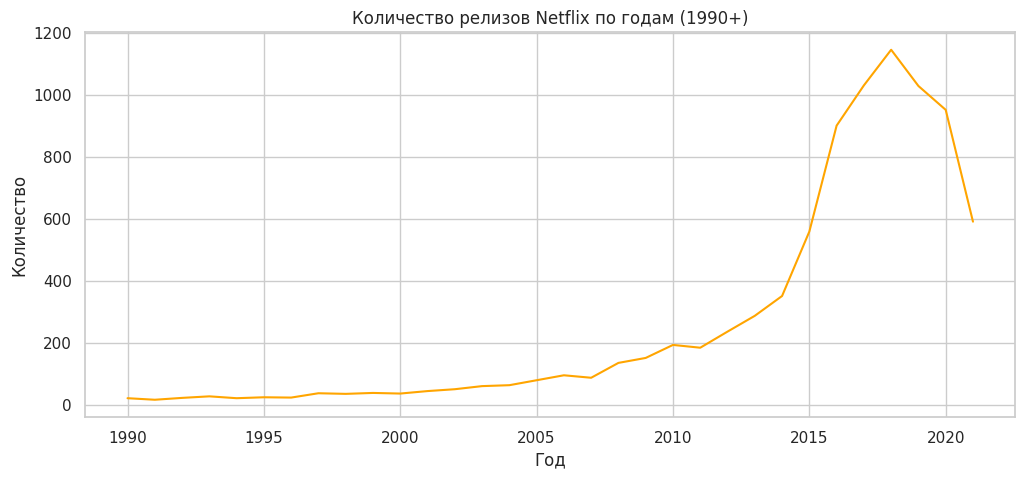

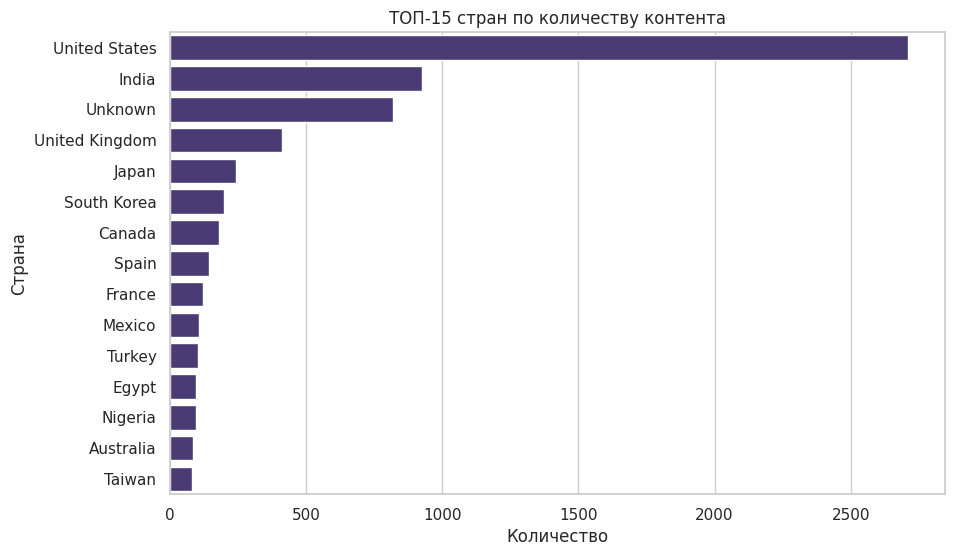

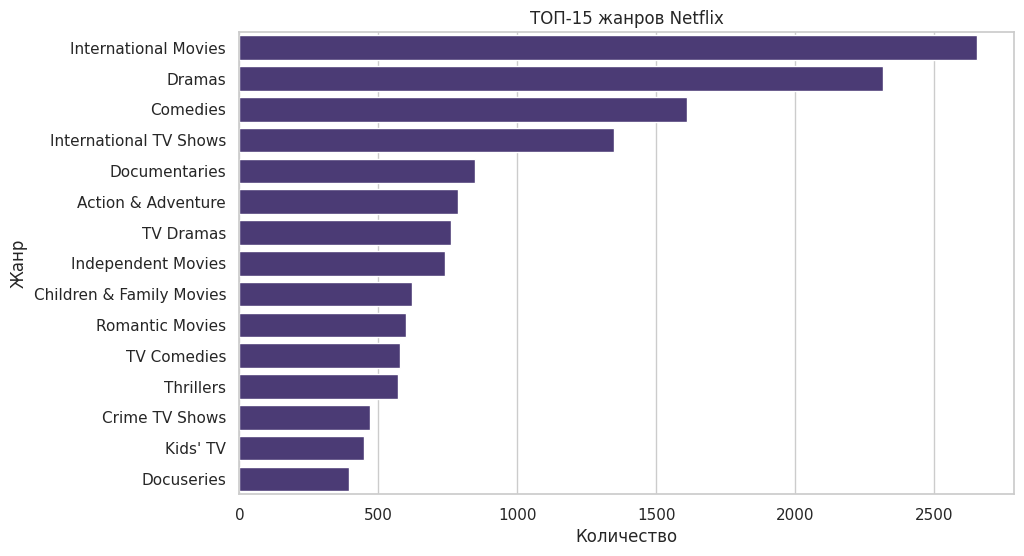

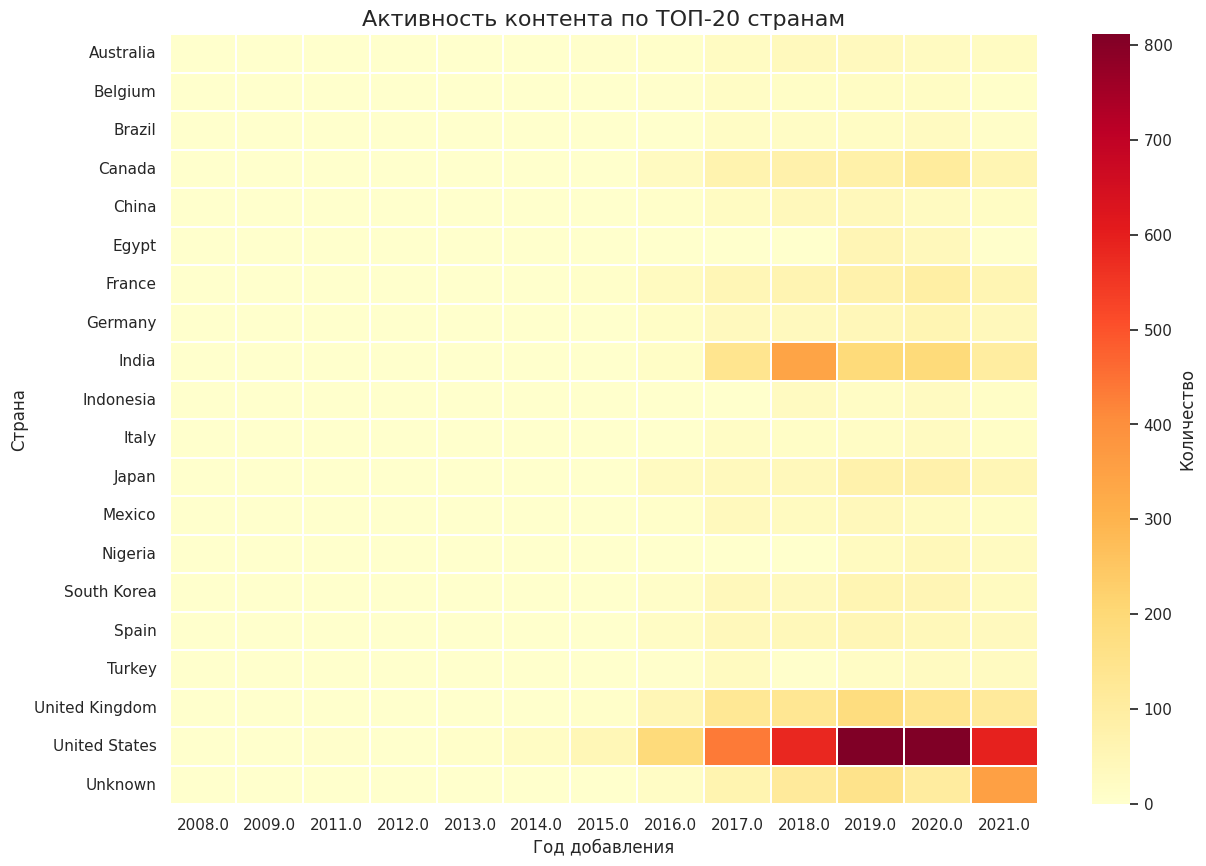

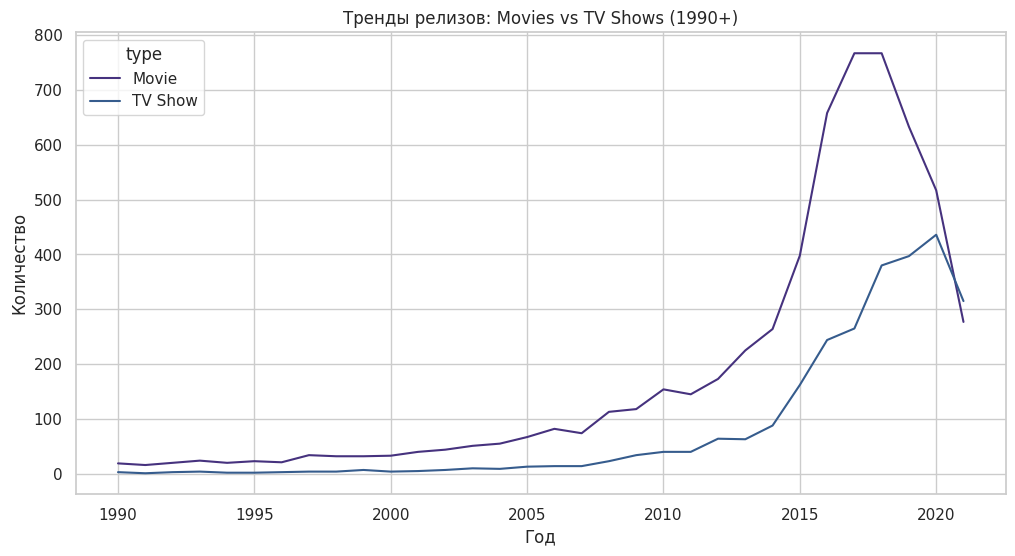

Анализ полностью завершён!


In [9]:
# ======================================================
#     ТЕМА 7: Анализ контента Netflix
#     Полный исправленный Colab-скрипт
# ======================================================

# -----------------------------
# 1. Import libraries
# -----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

sns.set(style="whitegrid", palette="viridis")


# -----------------------------
# 2. Load dataset
# -----------------------------
df = pd.read_csv("/content/netflix_titles.csv")

# Filter only 1990+
df = df[df["release_year"] >= 1990]


# -----------------------------
# 3. Preprocessing
# -----------------------------
df["country"] = df["country"].fillna("Unknown")
df["listed_in"] = df["listed_in"].fillna("Unknown")
df["date_added"] = pd.to_datetime(df["date_added"], errors="coerce")
df["year_added"] = df["date_added"].dt.year
df["genre_list"] = df["listed_in"].str.split(", ")


# ======================================================
#                 EDA SECTION
# ======================================================

# -----------------------------
# 4. Release count by year
# -----------------------------
release_count = df.groupby("release_year").size().reset_index(name="count")

plt.figure(figsize=(12,5))
sns.lineplot(data=release_count, x="release_year", y="count", color="orange")
plt.title("Количество релизов Netflix по годам (1990+)")
plt.xlabel("Год")
plt.ylabel("Количество")
plt.show()

px.line(
    release_count,
    x="release_year",
    y="count",
    title="Релизы Netflix по годам (1990+, интерактив)"
).show()


# -----------------------------
# 5. Top Countries
# -----------------------------
top_countries = df["country"].value_counts().head(15)

plt.figure(figsize=(10,6))
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title("ТОП-15 стран по количеству контента")
plt.xlabel("Количество")
plt.ylabel("Страна")
plt.show()


# -----------------------------
# 6. Top Genres
# -----------------------------
genre_expanded = df["listed_in"].str.split(", ").explode()
top_genres = genre_expanded.value_counts().head(15)

plt.figure(figsize=(10,6))
sns.barplot(x=top_genres.values, y=top_genres.index)
plt.title("ТОП-15 жанров Netflix")
plt.xlabel("Количество")
plt.ylabel("Жанр")
plt.show()


# -----------------------------
# 7. Treemap by Genre & Type
# -----------------------------
df_exploded = df.explode("genre_list")

genre_type = df_exploded.groupby(["genre_list", "type"]).size().reset_index(name="count")

fig = px.treemap(
    genre_type,
    path=["genre_list", "type"],
    values="count",
    title="Жанровая структура контента Netflix (Treemap)"
)
fig.show()

# Разделяем список стран как и жанры
df["country_list"] = df["country"].str.split(", ")

df_countries = df.explode("country_list")


# === Heatmap по ТОП-20 стран ===

# Разделяем страны
df["country_list"] = df["country"].str.split(", ")
df_c = df.explode("country_list")

# Топ стран
top20 = df_c["country_list"].value_counts().head(20).index
df_c = df_c[df_c["country_list"].isin(top20)]

# Группа по годам
heat = df_c.groupby(["country_list", "year_added"]).size().reset_index(name="count")



pivot = heat.pivot(index="country_list", columns="year_added", values="count").fillna(0)

plt.figure(figsize=(14,10))
sns.heatmap(
    pivot,
    cmap="YlOrRd",      # жёлтый → красный (тёплый)
    linewidths=0.3,
    linecolor="white",
    cbar_kws={'label': 'Количество'}
)
plt.title("Активность контента по ТОП-20 странам", fontsize=16)
plt.xlabel("Год добавления", fontsize=12)
plt.ylabel("Страна", fontsize=12)
plt.show()





# -----------------------------
# 9. Movies vs TV Shows trends
# -----------------------------
type_year = df.groupby(["release_year","type"]).size().reset_index(name="count")

plt.figure(figsize=(12,6))
sns.lineplot(data=type_year, x="release_year", y="count", hue="type")
plt.title("Тренды релизов: Movies vs TV Shows (1990+)")
plt.xlabel("Год")
plt.ylabel("Количество")
plt.show()


# ======================================================
#             CLUSTERING SECTION
# ======================================================

# -----------------------------
# 10. One-hot encode genres
# -----------------------------
df = df.reset_index(drop=True)  # ВАЖНО!

mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(df["genre_list"])
genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_)

# -----------------------------
# 11. One-hot encode top20 countries
# -----------------------------
top20 = df["country"].value_counts().head(20).index
df["country_cluster"] = df["country"].apply(lambda x: x if x in top20 else "Other")
country_df = pd.get_dummies(df["country_cluster"])

# -----------------------------
# 12. Combine matrices
# -----------------------------
cluster_data = pd.concat([genre_df.reset_index(drop=True),
                          country_df.reset_index(drop=True)], axis=1)

cluster_data = cluster_data.fillna(0)

# -----------------------------
# 13. PCA
# -----------------------------
pca = PCA(n_components=2)
coords = pca.fit_transform(cluster_data)

# -----------------------------
# 14. KMeans
# -----------------------------
kmeans = KMeans(n_clusters=6, random_state=42)
df["cluster"] = kmeans.fit_predict(cluster_data)



# -----------------------------
# 15. Cluster Visualization
# -----------------------------
fig = px.scatter(
    x=coords[:,0],
    y=coords[:,1],
    color=df["cluster"].astype(str),
    hover_name=df["title"],
    title="Кластеры контента Netflix (PCA + KMeans)"
)
fig.show()

print("Анализ полностью завершён!")
